<a href="https://colab.research.google.com/github/pkscanvas/Optimal-Satellite-Pose-Estimation-/blob/master/Copy_of_Speedv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mounting the Google Drive to access the dataset.**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


Importing all necessary packages.


*   The **preprocess_input** function is meant to adequate your image to the format the model requires
*  **ImageDataGenerator:** Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).



In [0]:

dataset_root="/content/gdrive/My Drive/Colab Notebooks/speed"
import pandas as pd
import os
import json
import numpy as np
import keras
import tensorflow
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception
from keras.applications.xception import preprocess_input  
from keras.models import Model
from keras.layers import Dense,Flatten,BatchNormalization,Activation,AlphaDropout
from sklearn.model_selection import train_test_split

  

Using TensorFlow backend.




1.   **with:** there is no need to call file.close() when using with statement. The with statement itself ensures proper acquisition and release of resource, it also takes care of all the exceptions by itself
2.   **os.path** contains functions for manipulating filenames and directory names.
3.**os.path.join()** function will add an extra slash to the pathname before joining it to the filename.



In [0]:
with open(os.path.join(dataset_root,'train.json'),'r') as train:
  train_json=json.load(train)
train_json[0]['q_vbs2tango']
#len(train_json)
type(train_json)
# q=train_json[i]['q_vbs2tango']
# r=train_json[i]['r_Vo2To_vbs_true']
# a=q.extend(r)


list

In [0]:
imgname_list=[]
for i in range(len(train_json)):
  imgname_list.append(train_json[i]['filename'])

#imgname_list

Putting all the images and corresponding 7 continuous values (4 from quaternion vector, 3 from position vector) in a Pandas dataframe to be able to use with **flow_from_dataframe** function
for multilabel regression.

In [0]:
label_list=[]
q1,q2,q3,q4,r1,r2,r3=[],[],[],[],[],[],[]
for i in range(len(train_json)):
  q1.append(train_json[i]['q_vbs2tango'][0])
  q2.append(train_json[i]['q_vbs2tango'][1])
  q3.append(train_json[i]['q_vbs2tango'][2])
  q4.append(train_json[i]['q_vbs2tango'][3])
  r1.append(train_json[i]['r_Vo2To_vbs_true'][0])
  r2.append(train_json[i]['r_Vo2To_vbs_true'][1])
  r3.append(train_json[i]['r_Vo2To_vbs_true'][2])
  #q.extend(r)
  #label_list.append(q)



In [0]:
col_dict={'image_names':imgname_list,'q1':q1,'q2':q2,'q3':q3,'q4':q4,'r1':r1,'r2':r2,'r3':r3}
df=pd.DataFrame(col_dict)
#df['labels']=label_list
df_train,df_test=train_test_split(df,test_size=0.2)
len(df_test)
df_train.head()

,image_names,q1,q2,q3,q4,r1,r2,r3
10572,img013233.jpg,-0.503782,0.646529,-0.444970,-0.360841,0.162846,0.019178,6.359701
520,img000660.jpg,0.034388,-0.234132,-0.330508,0.913654,-0.070732,0.089792,9.142628
5819,img007283.jpg,0.446367,-0.806015,0.348459,0.172254,-0.253876,-0.973054,25.551743
2768,img003486.jpg,-0.356865,-0.027647,-0.906469,0.224049,-0.261687,0.113041,16.623442
6256,img007830.jpg,-0.808217,0.101052,-0.535798,0.222473,0.123366,0.225897,23.779483


Previously, one should have to write a custom generator if they have to perform regression or predict multiple columns and utilize the image augmentation capabilities of the ImageDataGenerator, now we can have the target values as just another column/s (must be numerical datatype) in our dataframe, simply provide the column names to the **flow_from_dataframe** and we can now use all the augmentations provided by the ImageDataGenerator

In [0]:
path="/content/gdrive/My Drive/Colab Notebooks/speed/images/train"
cols=['q1','q2','q3','q4','r1','r2','r3']
datagen=ImageDataGenerator(preprocessing_function=preprocess_input,zoom_range=0.2,brightness_range=[0.8,1.2]) #Values less than 1.0 darken the image, e.g. [0.5, 1.0], whereas values larger than 1.0 brighten the image, e.g. [1.0, 1.5], where 1.0 has no effect on brightness.
datagen2=ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator=datagen.flow_from_dataframe(df_train,directory=path,x_col='image_names',y_col=cols,class_mode='other',target_size=(299,299),batch_size=32,color_mode='rgb')
validation_generator=datagen2.flow_from_dataframe(df_test,directory=path,x_col='image_names',y_col=cols,class_mode='other',target_size=(299,299),batch_size=32,color_mode='rgb')


Found 9600 validated image filenames.
Found 2400 validated image filenames.


In [0]:
len(train_generator)

300

**Building our model using Transfer Learning.**

In [0]:

#tensorflow.keras.backend.set_learning_phase(0)
model_pretrained=Xception(weights='imagenet',include_top=False,input_shape=(299,299,3))
#tensorflow.keras.backend.set_learning_phase(1)

#using keras functional api to build our model

x=model_pretrained.output

#x=Flatten()(x)

#x=Dense(32,activation='selu',kernel_initializer='lecun_normal')(x)
        
#x=BatchNormalization()(x)

x=Dense(1024,activation='selu',kernel_initializer='lecun_normal')(x) #
   
x=AlphaDropout(0.1)(x)
        
# x=Dense(64,activation='selu',kernel_initializer='lecun_normal')(x) #
   
# x=AlphaDropout(0.1)(x)

#x=BatchNormalization()(x)
        
#x=Dense(128,activation='selu',kernel_initializer='lecun_normal')(x)
        
x=Flatten()(x)
        
x=Dense(7,activation='linear')(x)

model=Model(inputs=model_pretrained.input,outputs=x)


# step_size_train=train_generator.n//train_generator.batch_size #It should typically be equal to the number of samples of your dataset divided by the batch size.
# step_size_valid=validation_generator.n//validation_generator.batch_size
# history=model.fit_generator(train_generator,steps_per_epoch=step_size_train,epochs=2,validation_data=validation_generator,validation_steps=step_size_valid)


W0725 13:27:40.092952 139808584177536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 13:27:40.117626 139808584177536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 13:27:40.122889 139808584177536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 13:27:40.151213 139808584177536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0725 13:27:40.152497 1398085841

**IMP** Which layers to train or not should be done before model compilation.

In [0]:
# train_generator[0][0][0][0][0]
# train_generator

In [0]:
for i,j in enumerate(model.layers):
  print(i,':',j)
for layer in model.layers[:17]:
  layer.trainable=False
for layer in model.layers[17:]:
  layer.trainable=True

0 : <keras.engine.input_layer.InputLayer object at 0x7f2795da7860>
1 : <keras.layers.convolutional.Conv2D object at 0x7f2795da7390>
2 : <keras.layers.normalization.BatchNormalization object at 0x7f2795da75c0>
3 : <keras.layers.core.Activation object at 0x7f2765340240>
4 : <keras.layers.convolutional.Conv2D object at 0x7f27510c1f98>
5 : <keras.layers.normalization.BatchNormalization object at 0x7f27510e1e80>
6 : <keras.layers.core.Activation object at 0x7f2751054cc0>
7 : <keras.layers.convolutional.SeparableConv2D object at 0x7f2750ff5400>
8 : <keras.layers.normalization.BatchNormalization object at 0x7f2750f0cf98>
9 : <keras.layers.core.Activation object at 0x7f2750eb0d68>
10 : <keras.layers.convolutional.SeparableConv2D object at 0x7f2750e73240>
11 : <keras.layers.normalization.BatchNormalization object at 0x7f2750e24f98>
12 : <keras.layers.convolutional.Conv2D object at 0x7f2751024f98>
13 : <keras.layers.pooling.MaxPooling2D object at 0x7f2750db27b8>
14 : <keras.layers.normalization.

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [0]:

sgd=keras.optimizers.sgd(lr=1e-5,decay=0, momentum=0.9, nesterov=True)
adam=keras.optimizers.adam(lr=1e-5)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=3, min_lr=1e-10,mode='min',verbose=1)
early_stopping=keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='min',min_delta=0.01,restore_best_weights=True)
model.compile(optimizer=sgd,loss='mean_squared_error') #,metrics=['mse']
step_size_train=train_generator.n//train_generator.batch_size #It should typically be equal to the number of samples of your dataset divided by the batch size.
step_size_valid=validation_generator.n//validation_generator.batch_size
history=model.fit_generator(train_generator,steps_per_epoch=step_size_train,epochs=50,validation_data=validation_generator,validation_steps=step_size_valid,callbacks=[reduce_lr]) #,early_stopping


W0725 13:27:48.575665 139808584177536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Epoch 1/50
300/300 [==============================] - 7315s 24s/step - loss: 4.6838 - val_loss: 3.6280
Epoch 2/50
300/300 [==============================] - 696s 2s/step - loss: 2.8705 - val_loss: 3.3581
Epoch 3/50
300/300 [==============================] - 694s 2s/step - loss: 2.4522 - val_loss: 3.1343
Epoch 4/50
300/300 [==============================] - 700s 2s/step - loss: 2.2458 - val_loss: 2.9438
Epoch 5/50
300/300 [==============================] - 699s 2s/step - loss: 2.1260 - val_loss: 2.7445
Epoch 6/50
300/300 [==============================] - 700s 2s/step - loss: 1.9920 - val_loss: 2.9818
Epoch 7/50
300/300 [==============================] - 693s 2s/step - loss: 1.8832 - val_loss: 2.9747
Epoch 8/50
300/300 [==============================] - 694s 2s/step - loss: 1.8764 - val_loss: 2.9707

Epoch 00008: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 9/50
300/300 [==============================] - 689s 2s/step - loss: 1.7545 - val_loss: 2.6617
Epoch 10

In [0]:

for e,v in enumerate(history.history['val_loss']):
  print("Epoch ",e,":",v)

Epoch  0 : 3.6279833920796714
Epoch  1 : 3.3581006224950154
Epoch  2 : 3.1342660061518353
Epoch  3 : 2.943791054089864
Epoch  4 : 2.7444564723968505
Epoch  5 : 2.9818450768788654
Epoch  6 : 2.9746910309791565
Epoch  7 : 2.97069539864858
Epoch  8 : 2.6616809860865276
Epoch  9 : 2.6892836419741313
Epoch  10 : 2.682108572324117
Epoch  11 : 2.7093078072865806
Epoch  12 : 2.7158721780776975
Epoch  13 : 2.6789696804682412
Epoch  14 : 2.6446347443262734
Epoch  15 : 2.6383742356300353
Epoch  16 : 2.639083806673686
Epoch  17 : 2.6064956760406495
Epoch  18 : 2.6679451656341553
Epoch  19 : 2.6121174494425454
Epoch  20 : 2.6259576710065207
Epoch  21 : 2.6371215836207074
Epoch  22 : 2.6333155552546184
Epoch  23 : 2.617523792584737
Epoch  24 : 2.6455794843037923
Epoch  25 : 2.6272151589393617
Epoch  26 : 2.6445490582784017
Epoch  27 : 2.658919450441996
Epoch  28 : 2.6523090902964275
Epoch  29 : 2.6158246405919394
Epoch  30 : 2.6553436660766603
Epoch  31 : 2.661392642656962
Epoch  32 : 2.611211991310

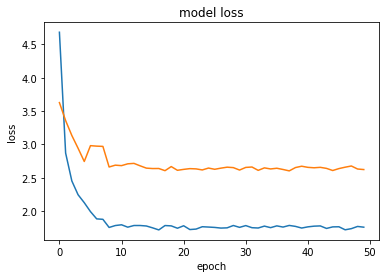

In [0]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


In [0]:
#Evaluating the model
test_result=[]
q_est,r_est=[],[]
with open(os.path.join(dataset_root,'real.json'),'r') as f_eval:
  test_list=json.load(f_eval)

for img in test_list:
  img_path=os.path.join(dataset_root,'images','real',img['filename'])
  img_arr=image.load_img(img_path,target_size=(299,299)) #This loads an image and resizes the image to (224, 224):
  x=image.img_to_array(img_arr) #The img_to_array() function adds channels: x.shape = (224, 224, 3) for RGB and (224, 224, 1) for gray image
  x=preprocess_input(x) #preprocess_input subtracts the mean RGB channels of the imagenet dataset. This is because the model you are using has been trained on a different dataset: x.shape is still (1, 224, 224, 3)
  x=np.expand_dims(x,axis=0) #expand_dims() is used to add the number of images: x.shape = (1, 224, 224, 3)
  output=model.predict(x)
  output=output.tolist()
  test_result.append({'filename':img['filename'],'q':output[:4],'r':output[4:]})
  q_est.append(output[0][:4])
  r_est.append(output[0][4:])
  print(output)


[[-0.22132007777690887, 0.10470885783433914, 0.15069890022277832, -0.3384361267089844, 0.778200626373291, 0.781964898109436, 5.462565898895264]]
[[0.2860822081565857, -0.15080243349075317, -0.030988097190856934, 0.029915502294898033, 0.3026317358016968, 0.42380762100219727, 4.1028618812561035]]
[[0.004015312530100346, -0.5273644924163818, -0.19559383392333984, 0.36415570974349976, -0.25776687264442444, 0.5487515330314636, 6.530252933502197]]
[[0.34322792291641235, 0.6643417477607727, -0.020405374467372894, 0.09958378225564957, -0.13867875933647156, 0.31973403692245483, 9.414289474487305]]
[[-0.04545758664608002, -0.3558104634284973, 0.08025423437356949, 0.15308086574077606, -0.5026021003723145, 0.4410761892795563, 4.536001205444336]]


In [0]:
# img_path=os.path.join(dataset_root,'images','test','img000014.jpg')
# img_arr=image.load_img(img_path,target_size=(299,299))
# x=image.img_to_array(img_arr)
# x=preprocess_input(x)
# x=np.expand_dims(x,axis=0)
# output=model.predict(x)
# output=output.tolist()
# output

**Extracting r_gt and q_gt from real.json**

In [0]:
real_json=[]
q_gt,r_gt=[],[]
with open(os.path.join(dataset_root,'real.json'),'r') as f:
  real_json=json.load(f)
for i in range(len(real_json)):
  q_gt.append(real_json[i]['q_vbs2tango'])
  r_gt.append(real_json[i]['r_Vo2To_vbs_true'])


**Calculating Orientation Score.**

Orientation score is the angle of the rotation, that aligns the estimated and ground truth orientations:

score(i)orientation=2⋅arccos(∣∣⟨q(i)est,q(i)gt⟩∣∣)

In [0]:
import math
score_orientation=0
bra_ket=[]
for i in range(len(real_json)):
  bra_ket.append(q_est[i][0]*q_gt[i][0]+q_est[i][1]*q_gt[i][1]+q_est[i][2]*q_gt[i][2]+q_est[i][3]*q_gt[i][3])
  
  
for i in range(len(real_json)):
  if bra_ket[i]<1:
    score_orientation+=2*math.acos(bra_ket[i])
score_orientation




15.895609107599252

**Calculating Position Score**

The position score for image i is simply the 2-norm of the position error (difference of estimated and ground truth position vectors), normalized with the ground truth distance of the satellite:

score(i)position=∣∣r(i)gt−r(i)est∣∣2∣∣r(i)gt∣∣2

In [0]:
from numpy import linalg
score_position=0
for i in range(len(real_json)):
   score_position+=(abs(linalg.norm([r_gt[i]],2)-linalg.norm([r_est[i]],2))/linalg.norm([r_gt[i]],2))

#linalg.norm([r_gt[0]])
score_position

2.8451222886828966

**Finally, the total score is the average of pose scores over all images of the test set:**

In [0]:
score=(score_orientation+score_position)/len(real_json)
score

3.74814627925643